# Bio-ClinicalBert Model Training


## Set Up

In [1]:
# !pip install transformers datasets accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 29.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 4.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 2.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 770.4/770.4 kB 7.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.0 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.4 MB/s eta 0

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
# cd drive/MyDrive/w210_Capstone/
%cd ..

/home/ubuntu/capstone-project


In [2]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from transformers import AdamW, get_cosine_schedule_with_warmup
from datasets import load_metric, load_dataset

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

from logging import warning
import warnings
warnings.filterwarnings('ignore')

In [3]:

if torch.cuda.is_available():
    # device = torch.device("cuda")
    device = "cuda"
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    # device = torch.device("cpu")
    device = "cpu"

Number of GPU(s) available: 1
GPU device name: NVIDIA A10G


In [89]:
RANDOM_SEED = 22
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
cudnn.deterministic = True

## Training Manually - Unfreeze Last Layer

### Build Model

In [90]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 30
LEARNING_RATE = 6e-4
# LEARNING_RATE = 0.7
# LEARNING_RATE = 0.9
# LEARNING_RATE = 0.5
# LEARNING_RATE = 0.0963
# MOMENTUM = 0.9
WEIGHT_DECAY = 1e-2
WORKERS = int(os.cpu_count())

In [91]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [92]:
# BERT Model
class BioBertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=68, hidden_size2=54, hidden_size3=40, dropout=0.1, unfreeze=False):
        super(BioBertClassification, self).__init__()
        self.bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

        # Unfreeze the last DistilBERT transformer layer
        if unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True
        else:
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)
        self.hidden_layer2 = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3 = nn.Linear(self.hidden_size2, self.hidden_size3)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size3, output_dim)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)

        pooler_token = bert_output[1]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        output = self.Sigmoid(self.classification(hidden_ouput))
        output = output.flatten()

        return output

In [93]:
# Initialize model, Unfreeze the last layer
model = BioBertClassification(unfreeze="last layer")
model = model.to(device)

#load the pre-trained BioBERT model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Print out models params for checking
params = list(model.named_parameters())
for p in params[-30:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert_model.encoder.layer.10.output.dense.weight          (768, 3072)
bert_model.encoder.layer.10.output.dense.bias                 (768,)
bert_model.encoder.layer.10.output.LayerNorm.weight           (768,)
bert_model.encoder.layer.10.output.LayerNorm.bias             (768,)
bert_model.encoder.layer.11.attention.self.query.weight   (768, 768)
bert_model.encoder.layer.11.attention.self.query.bias         (768,)
bert_model.encoder.layer.11.attention.self.key.weight     (768, 768)
bert_model.encoder.layer.11.attention.self.key.bias           (768,)
bert_model.encoder.layer.11.attention.self.value.weight   (768, 768)
bert_model.encoder.layer.11.attention.self.value.bias         (768,)
bert_model.encoder.layer.11.attention.output.dense.weight   (768, 768)
bert_model.encoder.layer.11.attention.output.dense.bias       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.weight       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.bias       (768,)
bert_model.encoder.lay

In [30]:
model

BioBertClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

### Build DataLoader

In [10]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary.csv'
test_file = 'data/binary_ddi/ddi_test_binary.csv'

df_train = pd.read_csv(train_file, sep='\t')
df_val= pd.read_csv(dev_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()

mean length of smiles1: 62.479706666666665
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.77145
min length of smiles2: 3
max length of smiles2: 748
Value Counts of Labels in Train Set:


interaction_type
1    150000
0    150000
Name: count, dtype: int64

In [11]:
from sklearn.utils import resample

# Choose a smaller subset of val data for faster training
df_val_small = resample(df_val,
                        replace=False,     # sample without replacement
                        n_samples=30000,
                        random_state=42) 
print(df_val_small.shape)
df_val_small.head(2)

(30000, 9)


,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
92216,DB01045,DB01207,Rifampicin,Ridogrel,Unknown,0,unknown,CO[C@H]1\C=C\O[C@@]2(C)OC3=C(C2=O)C2=C(O)C(\C=...,OC(=O)CCCCO\N=C(\C1=CN=CC=C1)C1=CC(=CC=C1)C(F)...
154483,DB12086,DB01288,Oxitropium,Fenoterol,The risk or severity of adverse effects can be...,1,high,CC[N+]1(C)[C@H]2C[C@@H](C[C@@H]1[C@H]1O[C@@H]2...,CC(CC1=CC=C(O)C=C1)NCC(O)C1=CC(O)=CC(O)=C1


In [15]:
## TEST BLOCK - TEST TOKENIZER
# Add features column which is a combination of smiles1 & smiles2
# Truncate each smiles to 254 tokens max, leaving min 3 tokens for CLS & SEP token
seperator = " [SEP] "
max_length = 512
df_val_small["features"] = df_val_small["smiles1"].str[:254] + seperator + ' ' + df_val_small["smiles2"].str[:254]
X_val = df_val_small["features"]
y_val = df_val_small["interaction_type"]

# Tokenize
_encodings = tokenizer(
    list(X_val.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_token_type_ids=False,
    return_tensors='pt'
)

_encodings

{'input_ids': tensor([[  101,  1884,   164,  ...,     0,     0,     0],
        [  101, 14402,   164,  ...,     0,     0,     0],
        [  101, 14402,  1475,  ...,     0,     0,     0],
        ...,
        [  101, 14402,   164,  ...,     0,     0,     0],
        [  101, 14402, 13335,  ...,     0,     0,     0],
        [  101,   164,   177,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [17]:
df_val_small[df_val_small["features"].isnull()]

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2,features


In [12]:
# prefix = "[CLS] "
seperator = " [SEP] "
max_length = 512

def build_data_loader(df, shuffle=True):
    # Combine SMILES1 & SMILE2 Together, using [SEP] token to distingush between drug1 & drug2
    df["features"] = df["smiles1"].str[:254] + seperator + df["smiles2"].str[:254]
    X = df["features"]
    y = df["interaction_type"]

    # Tokenize
    _encodings = tokenizer(
        list(X.values), 
        max_length=max_length,
        truncation=True,
        pad_to_max_length=True, 
        return_token_type_ids=False,
        return_tensors='pt'
    )

    _ids = _encodings.input_ids
    _mask = _encodings.attention_mask
    _labels = torch.tensor(y.values)

    _dataset = TensorDataset(_ids, _mask, _labels)
    _loader = DataLoader(_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=WORKERS)

    return _loader

In [13]:
## Data Loader
# train_loader = DataLoader(encoded_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
train_loader = build_data_loader(df_train)

# val_loader = DataLoader(encoded_val_ds_small, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
# val_loader_full = DataLoader(encoded_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
val_loader = build_data_loader(df_val_small)
val_loader_full = build_data_loader(df_val, shuffle=False)

# test_loader = DataLoader(encoded_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_loader = build_data_loader(df_test, shuffle=False)

In [14]:
print('Train batches:', len(train_loader))
print('Val subset batches:', len(val_loader))
print('Val Full batches:', len(val_loader_full))
print('Test batches:', len(test_loader))

Train batches: 12500
Val subset batches: 1250
Val Full batches: 9920
Test batches: 7782


### Training

In [110]:
# !pip install torch-lr-finder
# from torch_lr_finder import LRFinder

# Initialize Model
model = BioBertClassification(unfreeze="last layer")
model = model.to(device)

# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
# optimizer = optim.Adadelta(model.parameters(), lr=1e-7, weight_decay=1e-2)
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-2)

# # LR finder  # This doesn't work for our model
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")

# lr_finder.range_test(train_loader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [111]:
# Function to adjust the Learning Rate manually for Finding a good learning rate
# Increase LR from 1e-7 to 10 in exponential manner
n_step_lr = 100
learning_rates = np.logspace(-7, 2, n_step_lr)

def adjust_learning_rate(optimizer, step):
    """This function is for testing different learning rate in an epoch to find the best LR range"""    
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rates[step]

learning_rates

array([1.00000000e-07, 1.20450354e-07, 1.45082878e-07, 1.74752840e-07,
       2.10490414e-07, 2.53536449e-07, 3.05385551e-07, 3.67837977e-07,
       4.43062146e-07, 5.33669923e-07, 6.42807312e-07, 7.74263683e-07,
       9.32603347e-07, 1.12332403e-06, 1.35304777e-06, 1.62975083e-06,
       1.96304065e-06, 2.36448941e-06, 2.84803587e-06, 3.43046929e-06,
       4.13201240e-06, 4.97702356e-06, 5.99484250e-06, 7.22080902e-06,
       8.69749003e-06, 1.04761575e-05, 1.26185688e-05, 1.51991108e-05,
       1.83073828e-05, 2.20513074e-05, 2.65608778e-05, 3.19926714e-05,
       3.85352859e-05, 4.64158883e-05, 5.59081018e-05, 6.73415066e-05,
       8.11130831e-05, 9.77009957e-05, 1.17681195e-04, 1.41747416e-04,
       1.70735265e-04, 2.05651231e-04, 2.47707636e-04, 2.98364724e-04,
       3.59381366e-04, 4.32876128e-04, 5.21400829e-04, 6.28029144e-04,
       7.56463328e-04, 9.11162756e-04, 1.09749877e-03, 1.32194115e-03,
       1.59228279e-03, 1.91791026e-03, 2.31012970e-03, 2.78255940e-03,
      

In [112]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [113]:
## Define Learning Rate Finding fuction
def train_LRFinder(train_loader, model, criterion, optimizer, verbose=True):  
    # reset total loss for each epoch
    total_loss = 0

    # LR Finding initialization
    losses = []
    lrs = []
    loss_100iters = 0
    

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader): 
        # zero out gradients in the optimizer each step
        optimizer.zero_grad()
        
        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)
    
        # compute output
        output = model(input_ids=ids, 
                      attention_mask=mask)

        # compute loss 
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()
        loss_100iters += loss.item()
        
        # compute gradient
        # backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()
        
        # Report progress 
        update_lr_step = len(train_loader)/n_step_lr  #step = 250
        if step % update_lr_step == 0 and not step == 0 and verbose==True:
            n_iter_lr = int(step//update_lr_step)
            # Average loss for the current LR
            loss_100iters = loss_100iters / update_lr_step
            lr = learning_rates[n_iter_lr]
            
            print('Batch {:>5,}  of  {:>5,}.   Step Loss {:0.4f}   Avg Loss {:0.4f}   Learning Rate {:}    Elapsed: {:}.'.format(
                 step, 
                 len(train_loader),
                 loss.item(),
                 loss_100iters,
                 lr,
                 format_time(time.time() - t0)))       

            # Add loss & lr to list for ploting later
            losses.append(loss_100iters)
            lrs.append(lr)

            # update learning rate
            # scheduler.step()
            adjust_learning_rate(optimizer, n_iter_lr)

            # Reset loss for next lr
            loss_100iters = 0

    # Last iteration
    loss_100iters = loss_100iters / update_lr_step
    # Add loss & lr to list for ploting later
    losses.append(loss_100iters)
    lrs.append(learning_rates[-1])
    
    avg_train_loss = total_loss / len(train_loader) 
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
          avg_train_loss,
          format_time(elapsed_time)
            ))
    
    # return model, avg_train_loss, elapsed_time
    return losses, lrs

In [114]:
print ('-----  Learning Rate Finder -----')
losses, lrs = train_LRFinder(train_loader, model, criterion, optimizer)
print('Losses Dim:', len(losses))
print('LR Dim:', len(lrs))

-----  Learning Rate Finder -----
Batch   125  of  12,500.   Step Loss 0.6963   Avg Loss 0.7030   Learning Rate 1.204503540258781e-07    Elapsed: 0:00:31.
Batch   250  of  12,500.   Step Loss 0.7180   Avg Loss 0.6965   Learning Rate 1.45082877849594e-07    Elapsed: 0:01:00.
Batch   375  of  12,500.   Step Loss 0.6677   Avg Loss 0.6958   Learning Rate 1.747528400007683e-07    Elapsed: 0:01:28.
Batch   500  of  12,500.   Step Loss 0.6912   Avg Loss 0.6978   Learning Rate 2.104904144512022e-07    Elapsed: 0:01:57.
Batch   625  of  12,500.   Step Loss 0.7093   Avg Loss 0.6957   Learning Rate 2.5353644939701113e-07    Elapsed: 0:02:26.
Batch   750  of  12,500.   Step Loss 0.7021   Avg Loss 0.6978   Learning Rate 3.0538555088334124e-07    Elapsed: 0:02:55.
Batch   875  of  12,500.   Step Loss 0.7084   Avg Loss 0.6970   Learning Rate 3.678379771828634e-07    Elapsed: 0:03:24.
Batch 1,000  of  12,500.   Step Loss 0.7228   Avg Loss 0.6967   Learning Rate 4.4306214575838777e-07    Elapsed: 0:03:

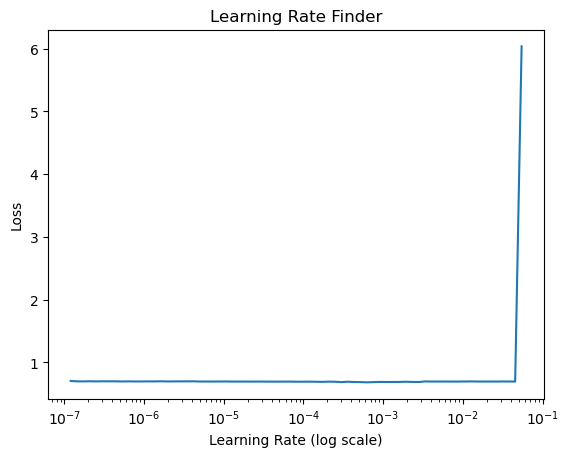

In [117]:
plt.title("Learning Rate Finder")
plt.ylabel("Loss")
plt.xlabel("Learning Rate (log scale)")
plt.plot(lrs[:71], losses[:71])
plt.xscale('log')

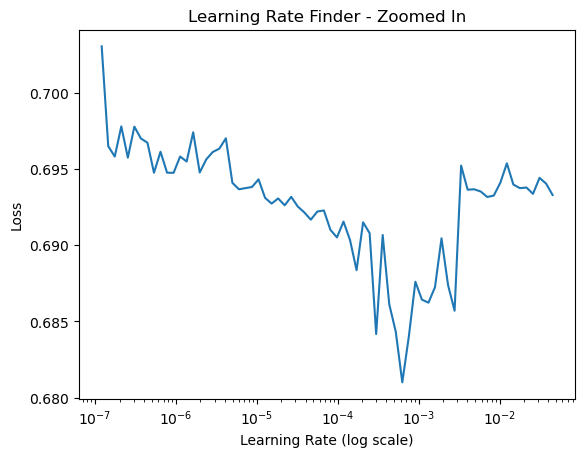

In [118]:
plt.title("Learning Rate Finder - Zoomed In")
plt.ylabel("Loss")
plt.xlabel("Learning Rate (log scale)")
plt.plot(lrs[:70], losses[:70])
plt.xscale('log')

In [127]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 30
LEARNING_RATE = 6.28e-4
WEIGHT_DECAY = 1e-2
WORKERS = int(os.cpu_count())

In [128]:
# from transformers import get_linear_schedule_with_warmup

# Initialize Model
model = BioBertClassification(unfreeze="last layer")
model = model.to(device)

# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
# optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min = 1e-7)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*T_max, num_training_steps=T_max)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [129]:
## Define train function
def train(train_loader, model, criterion, optimizer, verbose=True):  
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader):
        # zero out gradients in the optimizer each step
        optimizer.zero_grad()
        
        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)
    
        # compute output
        output = model(input_ids=ids, 
                      attention_mask=mask)

        # compute loss 
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()

        # Report progress every 200 batches
        if step % 1000 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                 step, 
                 len(train_loader),
                 loss.item(),
                 format_time(time.time() - t0))) 
        
        # compute gradient and do SGD
        # backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # update learning rate with scheduler
        scheduler.step()
        
    avg_train_loss = total_loss / len(train_loader) 
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
          avg_train_loss,
          format_time(elapsed_time)
            ))
    
    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time

In [130]:
## Define validate function
def validate(val_loader, model, criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for step, data in enumerate(val_loader):
            
            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            target = data[2].float().to(device)

            # compute output
            output = model(input_ids=ids,
                           attention_mask=mask)

            # compute loss
            loss = criterion(output, target)

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 1000 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step, 
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))        

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
          avg_val_loss,
          format_time(elapsed_time)
            ))
    
    return outputs, targets, avg_val_loss, elapsed_time


In [131]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
def compute_metrics(outputs, targets, prefix="Training"):
    y_pred = (np.array(outputs) >= 0.5).astype(float)
    y_score = np.array(outputs)
    y_true = np.array(targets)

    f2 =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")
    
    return y_true, y_score, y_pred

In [124]:
os.environ["TOKENIZERS_PARALLELISM"] = "TRUE"

In [125]:
filename = "models/checkpoint.pth.tar"

def save_checkpoint(state, is_best, filename=filename):
    torch.save(state, filename)

    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


best_train_loss = 1e5

In [132]:
# Test LR = 6.28e-4, Optim = AdamW
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []
learning_rates = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print('Learning rate:', str(scheduler.get_last_lr()[0]))
    learning_rates.append(scheduler.get_last_lr())
    
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred = compute_metrics(val_outputs, val_targets, prefix="Validation")
    print()

    # Get the best loss
    is_best = train_loss < best_train_loss
    best_train_loss = max(train_loss, best_train_loss)

    # Save Checkpoint
    save_checkpoint(
        {'epoch': epoch+1,
         'state_dict': model.state_dict(),
         'best_train_loss': best_train_loss,
         'optimizer': optimizer.state_dict()
        }, 
        is_best
    )

    if best_train_loss < 0.2:
        break

    

######  Epoch 1/30 ######
Learning rate: 0.000628
-----  Training -----
Batch 1,000  of  12,500.  Loss 0.6802  Elapsed: 0:03:53.
Batch 2,000  of  12,500.  Loss 0.7029  Elapsed: 0:07:44.
Batch 3,000  of  12,500.  Loss 0.7171  Elapsed: 0:11:35.
Batch 4,000  of  12,500.  Loss 0.6678  Elapsed: 0:15:26.
Batch 5,000  of  12,500.  Loss 0.6916  Elapsed: 0:19:17.
Batch 6,000  of  12,500.  Loss 0.7419  Elapsed: 0:23:06.
Batch 7,000  of  12,500.  Loss 0.7049  Elapsed: 0:26:56.
Batch 8,000  of  12,500.  Loss 0.6981  Elapsed: 0:30:46.
Batch 9,000  of  12,500.  Loss 0.6940  Elapsed: 0:34:35.
Batch 10,000  of  12,500.  Loss 0.6588  Elapsed: 0:38:25.
Batch 11,000  of  12,500.  Loss 0.6423  Elapsed: 0:42:15.
Batch 12,000  of  12,500.  Loss 0.7545  Elapsed: 0:46:05.

Avg Training Loss 0.6822, Completed in 0:48:03 

-----  Validation -----
Batch 1,000  of  1,250.  Loss 0.7216  Elapsed: 0:03:31.

Avg Validation Loss 0.6879, Completed in 0:04:26
Validation F2-score: 0.6577
Validation Matthew Correlation Co

In [65]:
# # LR = 0.7, Optim = Adadelta
# # Store the average loss after each epoch so we can plot them.
# train_loss_values = []
# val_loss_values = []


# for epoch in range(EPOCHS):
#     print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
#     print ('-----  Training -----')
#     train_loss, train_time = train(train_loader, model, criterion, optimizer)
#     train_loss_values.append(train_loss)

#     print ('-----  Validation -----')
#     val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
#     val_loss_values.append(val_loss)
#     y_val_true, y_val_score, y_val_pred = compute_metrics(val_outputs, val_targets, prefix="Validation")

#     # Get the best loss
#     is_best = train_loss < best_train_loss
#     best_train_loss = max(train_loss, best_train_loss)

#     # Save Checkpoint
#     save_checkpoint(
#         {'epoch': epoch+1,
#          'state_dict': model.state_dict(),
#          'best_train_loss': best_train_loss,
#          'optimizer': optimizer.state_dict()
#         }, 
#         is_best
#     )

#     if best_train_loss < 0.2:
#         break

#     print('Learning rate:', str(scheduler.get_last_lr()))

######  Epoch 1/100 ######
-----  Training -----
Batch 1,000  of  12,500.  Loss 0.6929  Elapsed: 0:03:52.
Batch 2,000  of  12,500.  Loss 0.7091  Elapsed: 0:07:41.
Batch 3,000  of  12,500.  Loss 0.6653  Elapsed: 0:11:31.
Batch 4,000  of  12,500.  Loss 0.6977  Elapsed: 0:15:21.
Batch 5,000  of  12,500.  Loss 0.6732  Elapsed: 0:19:10.
Batch 6,000  of  12,500.  Loss 0.6977  Elapsed: 0:22:59.
Batch 7,000  of  12,500.  Loss 0.6544  Elapsed: 0:26:49.
Batch 8,000  of  12,500.  Loss 0.6951  Elapsed: 0:30:38.
Batch 9,000  of  12,500.  Loss 0.7128  Elapsed: 0:34:28.
Batch 10,000  of  12,500.  Loss 0.6801  Elapsed: 0:38:16.
Batch 11,000  of  12,500.  Loss 0.6331  Elapsed: 0:42:05.
Batch 12,000  of  12,500.  Loss 0.6455  Elapsed: 0:45:55.

Avg Training Loss 0.6877, Completed in 0:47:52 

-----  Validation -----
Batch 1,000  of  1,250.  Loss 0.6407  Elapsed: 0:03:31.

Avg Validation Loss 0.6975, Completed in 0:04:25
Validation F2-score: 0.3922
Validation Matthew Correlation Coefficient: 0.052
Valida

KeyboardInterrupt: 

In [ ]:
# # LR  = 0.9, Optim = Adadelta
# # Store the average loss after each epoch so we can plot them.
# train_loss_values = []
# val_loss_values = []

# for epoch in range(EPOCHS):
#     print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
#     print ('-----  Training -----')
#     train_loss, train_time = train(train_loader, model, criterion, optimizer)
#     train_loss_values.append(train_loss)

#     print ('-----  Validation -----')
#     val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
#     val_loss_values.append(val_loss)
#     y_val_true, y_val_score, y_val_pred = compute_metrics(val_outputs, val_targets, prefix="Validation")

#     # Get the best loss
#     is_best = train_loss < best_train_loss
#     best_train_loss = max(train_loss, best_train_loss)

#     # Save Checkpoint
#     save_checkpoint(
#         {'epoch': epoch+1,
#          'state_dict': model.state_dict(),
#          'best_train_loss': best_train_loss,
#          'optimizer': optimizer.state_dict()
#         }, 
#         is_best
#     )

#     if best_train_loss < 0.2:
#         break

#     print()
#     print('Learning rate:', str(round(scheduler.get_last_lr(), 4)))

######  Epoch 1/100 ######
-----  Training -----
Batch 1,000  of  12,500.  Loss 0.6969  Elapsed: 0:03:52.
Batch 2,000  of  12,500.  Loss 0.6802  Elapsed: 0:07:43.
Batch 3,000  of  12,500.  Loss 0.6826  Elapsed: 0:11:34.
Batch 4,000  of  12,500.  Loss 0.7457  Elapsed: 0:15:23.
Batch 5,000  of  12,500.  Loss 0.6135  Elapsed: 0:19:13.
Batch 6,000  of  12,500.  Loss 0.6906  Elapsed: 0:23:03.
Batch 7,000  of  12,500.  Loss 0.6184  Elapsed: 0:26:53.
Batch 8,000  of  12,500.  Loss 0.6521  Elapsed: 0:30:43.
Batch 9,000  of  12,500.  Loss 0.6769  Elapsed: 0:34:33.
Batch 10,000  of  12,500.  Loss 0.6453  Elapsed: 0:38:22.
Batch 11,000  of  12,500.  Loss 0.6856  Elapsed: 0:42:10.
Batch 12,000  of  12,500.  Loss 0.6775  Elapsed: 0:45:59.

Avg Training Loss 0.6879, Completed in 0:47:57 

-----  Validation -----
Batch 1,000  of  1,250.  Loss 0.6708  Elapsed: 0:03:30.

Avg Validation Loss 0.6873, Completed in 0:04:24
Validation F2-score: 0.6649
Validation Matthew Correlation Coefficient: 0.0353
Valid

In [31]:
# # LR = 0.5, Optim = Adadelta
# # Store the average loss after each epoch so we can plot them.
# train_loss_values = []
# val_loss_values = []

# for epoch in range(EPOCHS):
#     print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
#     print ('-----  Training -----')
#     train_loss, train_time = train(train_loader, model, criterion, optimizer)
#     train_loss_values.append(train_loss)

#     print ('-----  Validation -----')
#     val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
#     val_loss_values.append(val_loss)
#     y_val_true, y_val_score, y_val_pred = compute_metrics(val_outputs, val_targets, prefix="Validation")

######  Epoch 1/4 ######
-----  Training -----
Batch 1,000  of  12,500.  Loss 0.6958  Elapsed: 0:05:04.
Batch 2,000  of  12,500.  Loss 0.7064  Elapsed: 0:08:57.
Batch 3,000  of  12,500.  Loss 0.7090  Elapsed: 0:12:51.
Batch 4,000  of  12,500.  Loss 0.6989  Elapsed: 0:16:44.
Batch 5,000  of  12,500.  Loss 0.6910  Elapsed: 0:20:37.
Batch 6,000  of  12,500.  Loss 0.6823  Elapsed: 0:24:30.
Batch 7,000  of  12,500.  Loss 0.7200  Elapsed: 0:28:23.
Batch 8,000  of  12,500.  Loss 0.6490  Elapsed: 0:32:17.
Batch 9,000  of  12,500.  Loss 0.6922  Elapsed: 0:36:09.
Batch 10,000  of  12,500.  Loss 0.7100  Elapsed: 0:40:02.
Batch 11,000  of  12,500.  Loss 0.7043  Elapsed: 0:43:55.
Batch 12,000  of  12,500.  Loss 0.7217  Elapsed: 0:47:48.

Avg Training Loss 0.6862, Completed in 0:49:50 

-----  Validation -----
Batch 1,000  of  1,250.  Loss 0.7137  Elapsed: 0:03:35.

Avg Validation Loss 0.6880, Completed in 0:04:33
Validation F2-score: 0.6722
Validation Matthew Correlation Coefficient: 0.0381
Validat

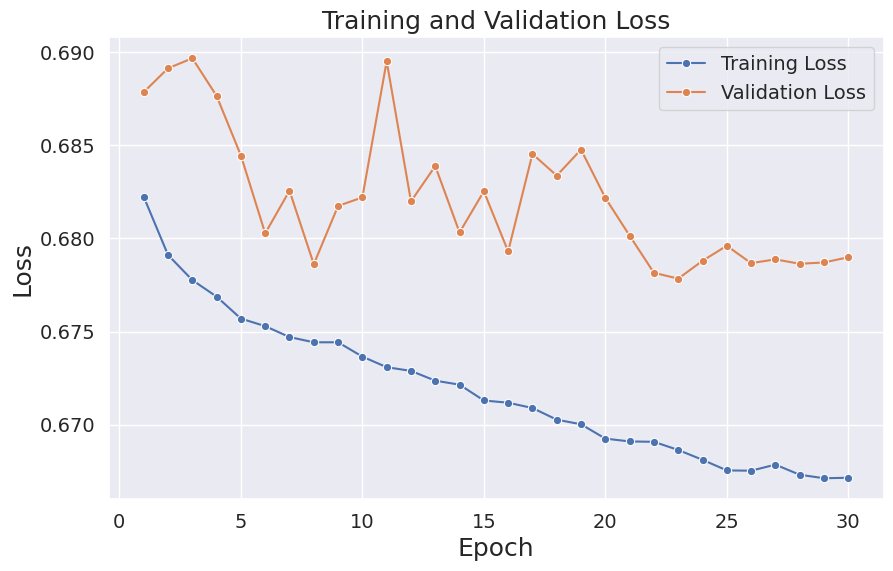

In [134]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 31), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)
# ax.set_ylim(0)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [135]:
torch.save(model.state_dict(), 'models/BioClinicalBertUnFrozen.pth')

### Evaluation

In [136]:
# Predicting with Test Set
print('\nEvaluation metrics for Test Set:')
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
y_test_true, y_test_score, y_test_pred = compute_metrics(test_outputs, test_targets, prefix="Testing")


Evaluation metrics for Test Set:
Testing F2-score: 0.6219
Testing Matthew Correlation Coefficient: 0.0631
Testing Recall: 0.6062
Testing Precision: 0.6937
Testing Accuracy: 0.5577


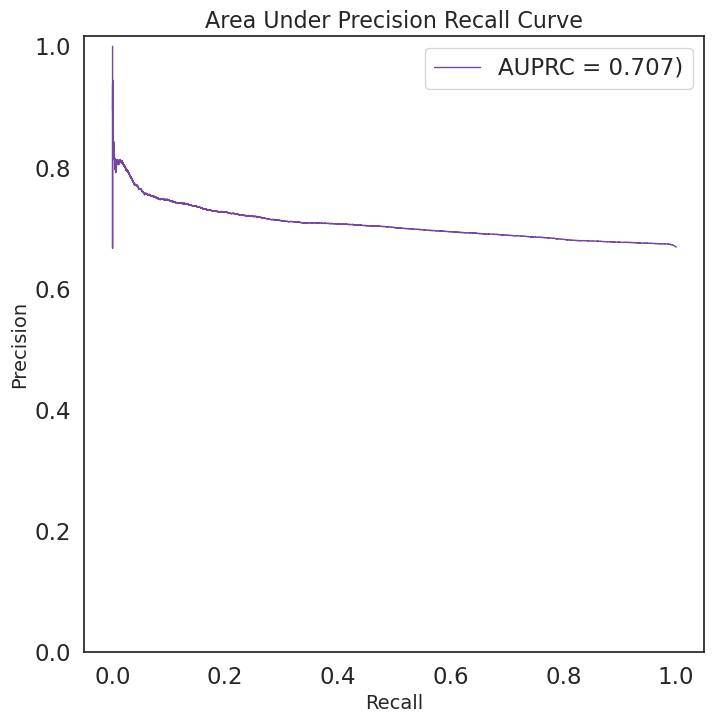

In [137]:
# Extract AUPRC & AP
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=1, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test_true, y_test_score)

In [138]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test_true, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.37      0.46      0.41     61872
     class 1       0.69      0.61      0.65    124881

    accuracy                           0.56    186753
   macro avg       0.53      0.53      0.53    186753
weighted avg       0.59      0.56      0.57    186753



In [139]:
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[45.98525989, 54.01474011],
       [39.3830927 , 60.6169073 ]])

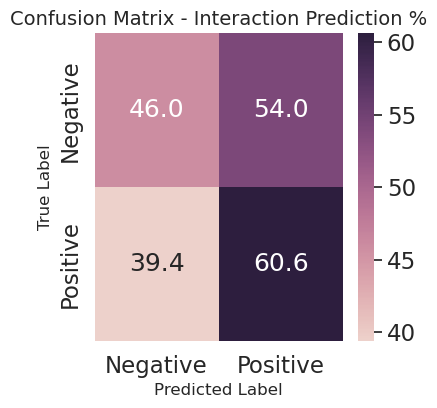

In [140]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_title("Confusion Matrix - Interaction Prediction %", fontsize=14)
    plt.show()

plot_conf_matrix_high(conf_matrix)

## Training - Unfreeze All Layers

### Build Model

In [23]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 8
LEARNING_RATE = 0.0963
# MOMENTUM = 0.9
WEIGHT_DECAY = 1e-2
WORKERS = int(os.cpu_count())

In [9]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [13]:
# Initialize model, Unfreeze all layers
model = BioBertClassification(unfreeze="all layers")
model = model.to(device)

#load the pre-trained BioBERT model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
## Data Loader
# train_loader = DataLoader(encoded_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
train_loader = build_data_loader(df_train)

# val_loader = DataLoader(encoded_val_ds_small, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
# val_loader_full = DataLoader(encoded_val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
val_loader = build_data_loader(df_val_small)
val_loader_full = build_data_loader(df_val, shuffle=False)

# test_loader = DataLoader(encoded_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_loader = build_data_loader(df_test, shuffle=False)

In [15]:
print('Train batches:', len(train_loader))
print('Val subset batches:', len(val_loader))
print('Val Full batches:', len(val_loader_full))
print('Test batches:', len(test_loader))

Train batches: 12500
Val subset batches: 1250
Val Full batches: 9920
Test batches: 7782


### Training

In [16]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [23]:
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred = compute_metrics(val_outputs, val_targets, prefix="Validation")

######  Epoch 1/4 ######
-----  Training -----
Batch 1,000  of  12,500.  Loss 0.6942  Elapsed: 0:10:27.
Batch 2,000  of  12,500.  Loss 0.6953  Elapsed: 0:20:52.
Batch 3,000  of  12,500.  Loss 0.6940  Elapsed: 0:31:16.
Batch 4,000  of  12,500.  Loss 0.6941  Elapsed: 0:41:40.
Batch 5,000  of  12,500.  Loss 0.6937  Elapsed: 0:52:04.
Batch 6,000  of  12,500.  Loss 0.6932  Elapsed: 1:02:28.
Batch 7,000  of  12,500.  Loss 0.6957  Elapsed: 1:12:52.
Batch 8,000  of  12,500.  Loss 0.6933  Elapsed: 1:23:15.
Batch 9,000  of  12,500.  Loss 0.6932  Elapsed: 1:33:38.
Batch 10,000  of  12,500.  Loss 0.6931  Elapsed: 1:44:01.
Batch 11,000  of  12,500.  Loss 0.6931  Elapsed: 1:54:23.
Batch 12,000  of  12,500.  Loss 0.6931  Elapsed: 2:04:44.

Avg Training Loss 0.6932, Completed in 2:09:57 

-----  Validation -----
Batch 1,000  of  1,250.  Loss 0.6931  Elapsed: 0:03:32.

Avg Validation Loss 0.6931, Completed in 0:04:28
Validation F2-score: 0.8647
Validation Matthew Correlation Coefficient: 0.0
Validation

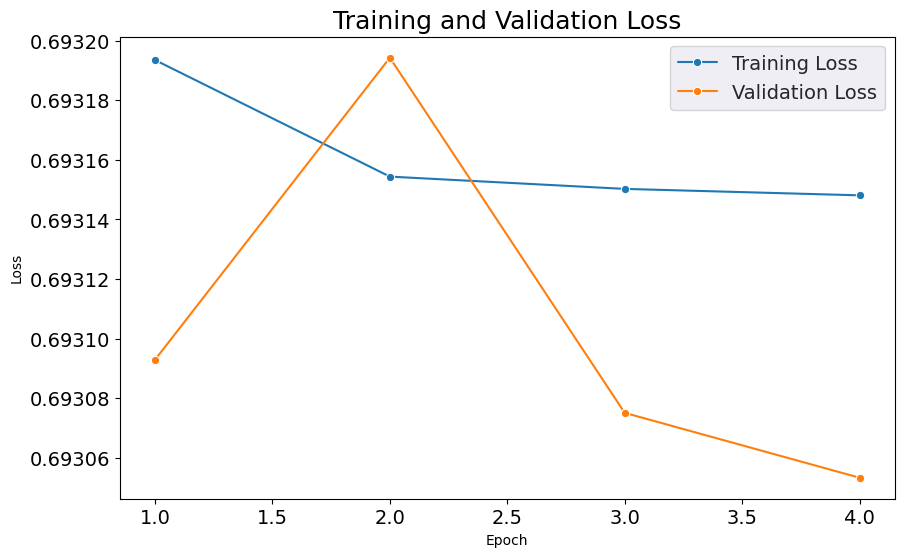

In [25]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 5), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [26]:
torch.save(model.state_dict(), 'models/BioClinicalBertUnFreezeAll.pth')

### Evaluation

In [27]:
# Predicting with Test Set
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
print('\nEvaluation metrics for Test Set:')
y_test_true, y_test_score, y_test_pred = compute_metrics(test_outputs, test_targets, prefix="Testing")


Evaluation metrics for Test Set:
Testing F2-score: 0.9098
Testing Matthew Correlation Coefficient: 0.0
Testing Recall: 1.0
Testing Precision: 0.6687
Testing Accuracy: 0.6687


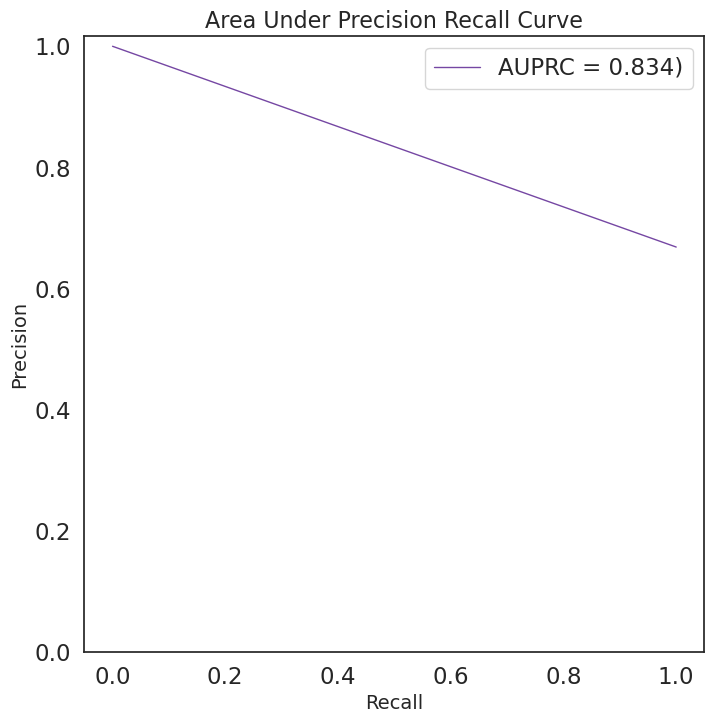

In [28]:
# Extract AUPRC & AP
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=1, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test_true, y_test_score)

In [29]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test_true, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00     61872
     class 1       0.67      1.00      0.80    124881

    accuracy                           0.67    186753
   macro avg       0.33      0.50      0.40    186753
weighted avg       0.45      0.67      0.54    186753



In [31]:
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[  0., 100.],
       [  0., 100.]])

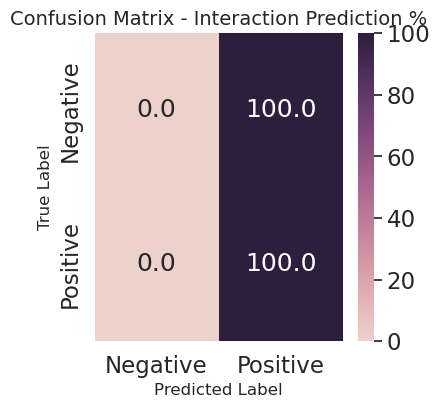

In [32]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_title("Confusion Matrix - Interaction Prediction %", fontsize=14)
    plt.show()

plot_conf_matrix_high(conf_matrix)